###                        Melanoma Detection

# Problem Statement

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The solution involves following steps


1.   Build a base model with the given data set of initial size. Evaluate the training and validation accuracy. Observe whether there is a overfit or underfit
2.   Perform manual data augmentation and observe the clarity in the images
3.   Use drop out and observe the training and validation accuracy
4.   Plot the distribution of images in each class and observe which class has got least number of images and which classes dominate proportionate number of images 
5.   Use augmentor library to create an additional 500 images in each class of the data and rebuild the model. Observe the train and validation accuary and write the conclusion whether data augmentation and class rebalance has helped to avoid overfit or underfit. Check whether there is an improvement in the accuary of the model
6. Predict on the test images



### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
import io

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# Data reading and understanding

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("gdrive/MyDrive/Skin_Cancer_ISIC/Train")
data_dir_test = pathlib.Path("gdrive/MyDrive/Skin_Cancer_ISIC/Test")
print(data_dir_train)
print(data_dir_test)

gdrive/MyDrive/Skin_Cancer_ISIC/Train
gdrive/MyDrive/Skin_Cancer_ISIC/Test


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total train images ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total test images ", image_count_test)

Total train images  2239
Total test images  118


### Load images using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size = (img_height,img_width),
                                                               seed=123, validation_split=0.2,
                                                               subset="training"
                                                               )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size = (img_height,img_width),
                                                               seed=123, validation_split=0.2,
                                                               subset="validation"
                                                               )


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Listing out all the classes of skin cancer and storing them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


Plotting an image from each of the classes

In [10]:
import matplotlib.pyplot as plt
subdir_lst = list()
img_file_lst = []
for classes in class_names:
  files_path = str(classes) + '/*'
  files_lst = list(data_dir_train.glob(files_path))
  img_file_lst.append(files_lst[0])

Image for the class  actinic keratosis


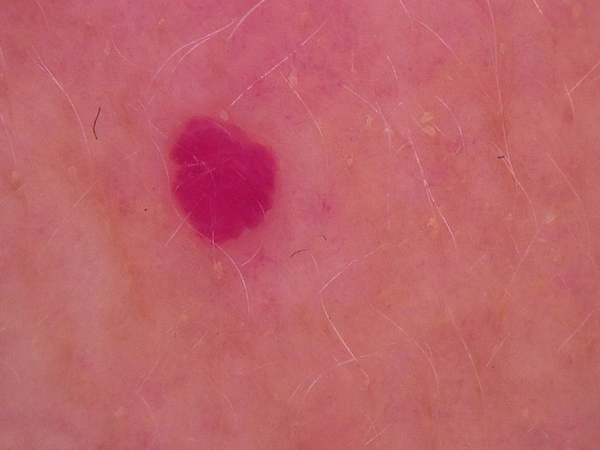

In [11]:
print("Image for the class ", class_names[0])
PIL.Image.open((files_lst[0]))


Image for the class  basal cell carcinoma


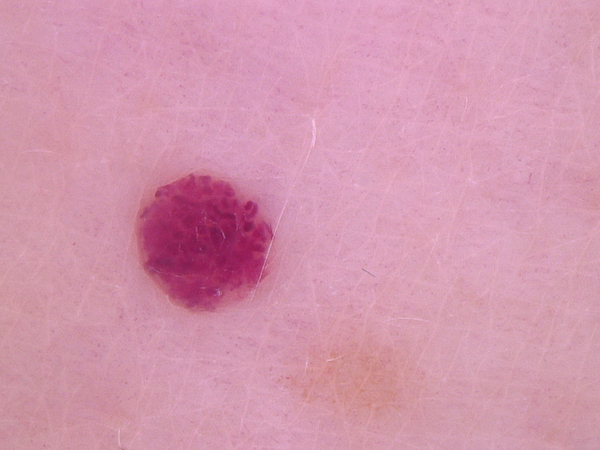

In [12]:
print("Image for the class ", class_names[1])
PIL.Image.open((files_lst[1]))

Image for the class  dermatofibroma


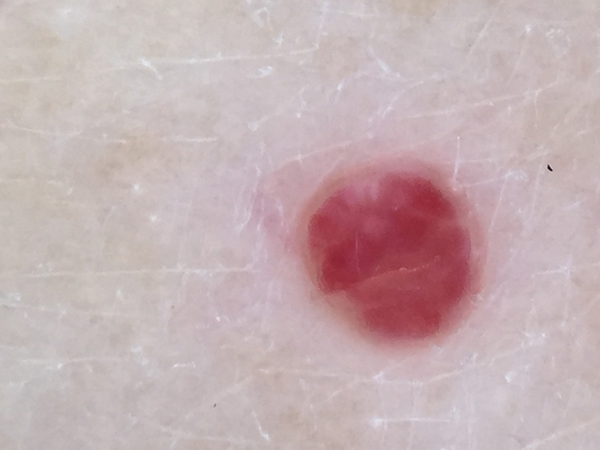

In [13]:
print("Image for the class ", class_names[2])
PIL.Image.open((files_lst[2]))

Image for the class  melanoma


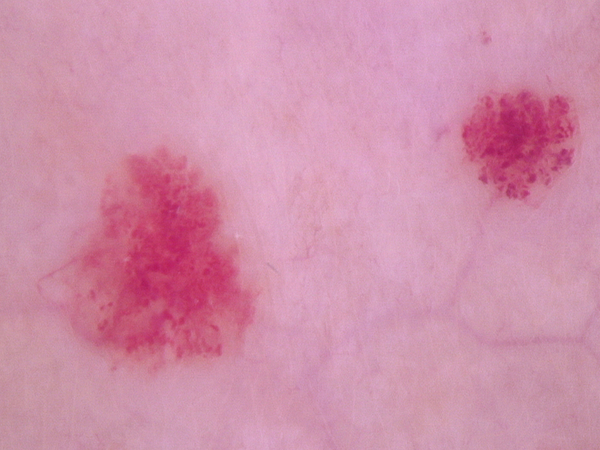

In [14]:
print("Image for the class ", class_names[3])
PIL.Image.open((files_lst[3]))

Image for the class  nevus


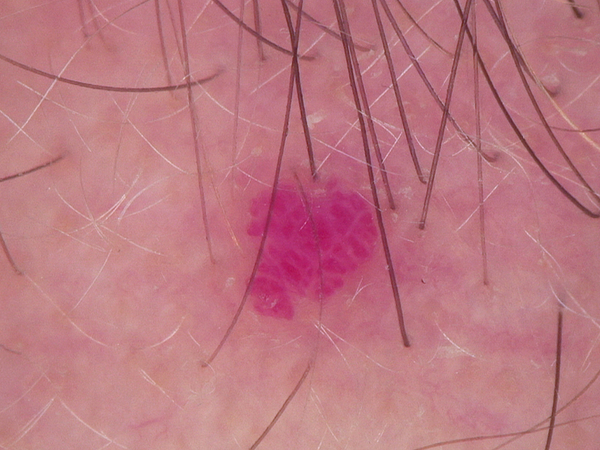

In [15]:
print("Image for the class ", class_names[4])
PIL.Image.open((files_lst[4]))

Image for the class  pigmented benign keratosis


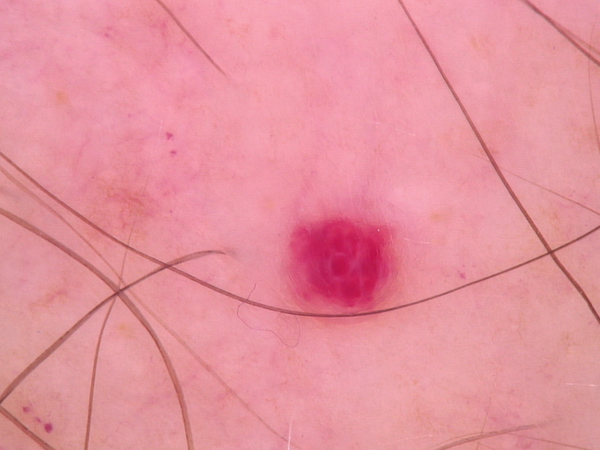

In [16]:
print("Image for the class ", class_names[5])
PIL.Image.open((files_lst[5]))

Image for the class  seborrheic keratosis


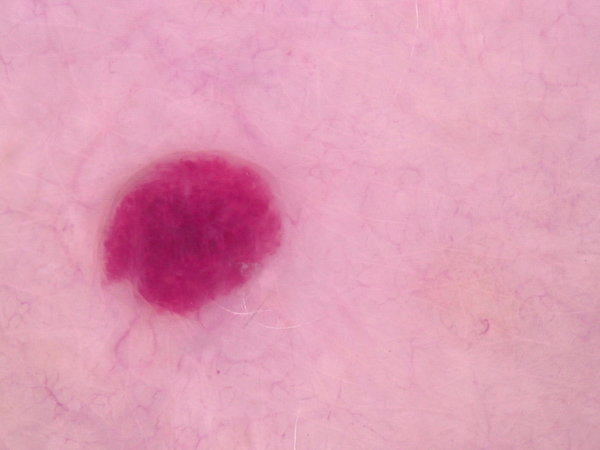

In [17]:
print("Image for the class ", class_names[6])
PIL.Image.open((files_lst[6]))

Image for the class  squamous cell carcinoma


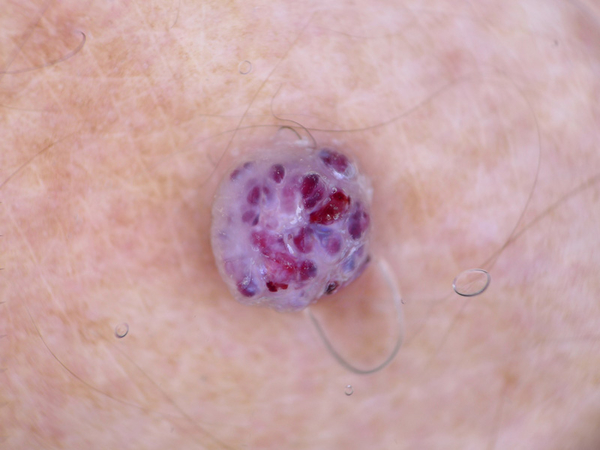

In [18]:
print("Image for the class ", class_names[7])
PIL.Image.open((files_lst[7]))

Image for the class  vascular lesion


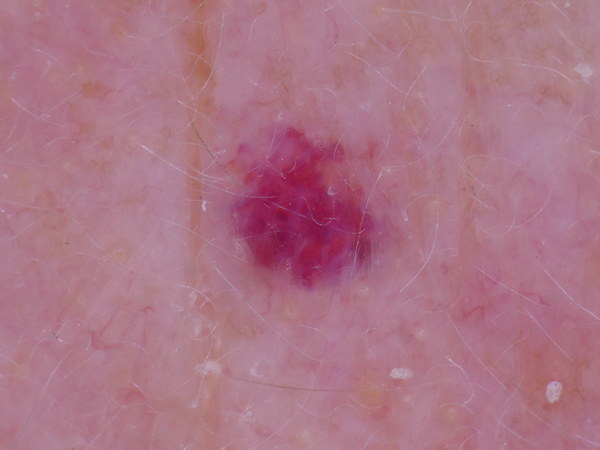

In [19]:
print("Image for the class ", class_names[8])
PIL.Image.open((files_lst[8]))

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the first model (Model 1)
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

The data standardization is taken care in the below code along with creating the sequential model

In [21]:
num_classes = len(class_names)
model = Sequential([
               layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
               layers.Conv2D(16, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Conv2D(32, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Conv2D(64, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Flatten(),
               layers.Dense(128, activation='relu'),
               layers.Dense(num_classes, activation='softmax')
])



### Compile the model (Model 1)
Choose an appropirate optimiser and loss function for model training 

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model (Model 1)

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 301s 1s/step - loss: 1.9599 - accuracy: 0.2818 - val_loss: 1.7988 - val_accuracy: 0.3490
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 1.5993 - accuracy: 0.4319 - val_loss: 1.4996 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4821 - accuracy: 0.4805 - val_loss: 1.4985 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4028 - accuracy: 0.5078 - val_loss: 1.4253 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2742 - accuracy: 0.5536 - val_loss: 1.3255 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.1833 - accuracy: 0.5753 - val_loss: 1.3386 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.1457 - accuracy: 0.5954 - val_loss: 1.3685 - val_accuracy: 0.5526
Epoch 8/20
56

### Visualizing training results for Model 1

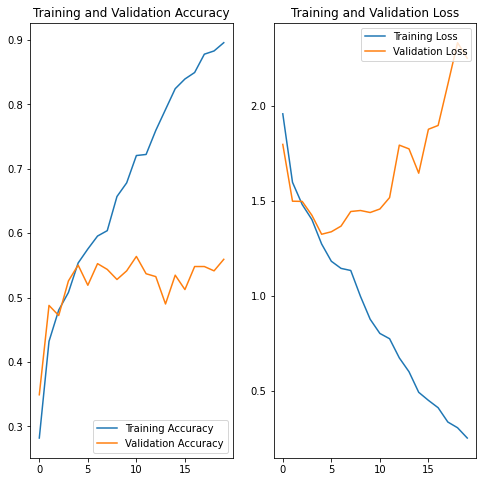

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of model building (Model 1) with the given initial data set

### Findings for Model 1

**This is the first model built and is named as Model 1**

Observing the above two plots for accuracy and loss, the findings are
1. After 20 epochs the train accuracy is 0.90 and the validation accuracy is 0.56
2. The train loss got reduced with number of epochs
3. The validation loss also got reduced ntil 7th epoch, but after that it got increased with number of epochs
4. There is a significant differance between train and validataion accuracy
4. We can clearly observe that the model is overfitted

# Chossing an augmentation techinque to overcome the overfitting

# Manual Data Augmentation

The reason for overfitting is the less number of training data. Data augmentation helps in tackling with overfitting. It generates additional data (augmentation of data) from the existing data by agumenting them using the random transformation. It yeilds the more similar like images. It will help the model to expose to a large number of data points and generalize better

In [26]:
# Data augmentation can be implemented using following preprocessing layers from keras
# RandomFlip, RandomRotation, RandomZoom
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
     layers.RandomRotation(0.4),
     layers.RandomZoom(0.4),
    ]
)

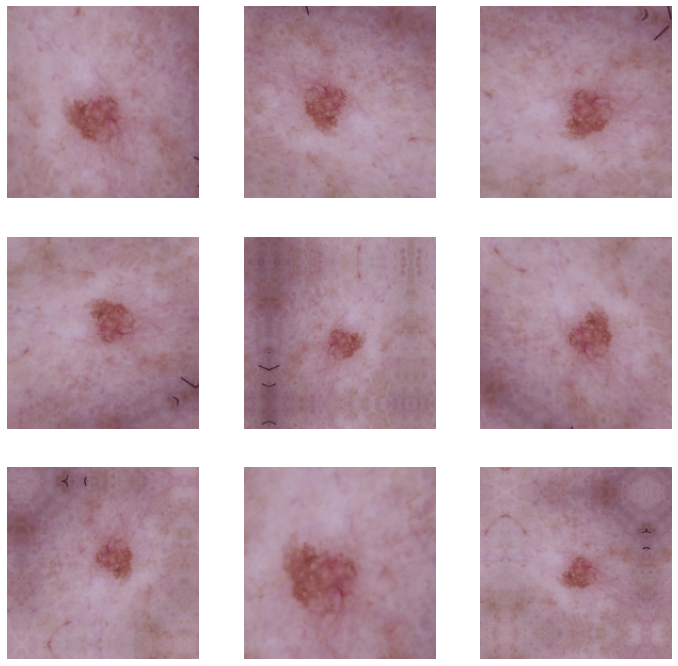

In [27]:
# Plotting images with data augmentation
plt.figure(figsize=(12,12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


# Build the next model (Model 2)


### Create the model (Model 2) with drop out, compile and train


In [37]:
## Dropout layer is introduced to overcome overfitting
model = Sequential([
               layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
               layers.Conv2D(16, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Conv2D(32, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Conv2D(64, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Flatten(),
               layers.Dense(128, activation='relu'),
               layers.Dense(num_classes, activation='softmax')
        ])

### Compiling the model (Model 2)

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model (Model 2)

In [40]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 67ms/step - loss: 2.3797 - accuracy: 0.1763 - val_loss: 2.0912 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0164 - accuracy: 0.2227 - val_loss: 2.0451 - val_accuracy: 0.2573
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.9398 - accuracy: 0.2829 - val_loss: 2.0969 - val_accuracy: 0.2215
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.7358 - accuracy: 0.3605 - val_loss: 1.8898 - val_accuracy: 0.3289
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6067 - accuracy: 0.4213 - val_loss: 1.6097 - val_accuracy: 0.4228
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.5568 - accuracy: 0.4263 - val_loss: 1.6442 - val_accuracy: 0.4161
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4992 - accuracy: 0.4632 - val_loss: 1.6215 - val_accuracy: 0.4541
Epoch 8/20
56

### Visualizing the results (Model 2)

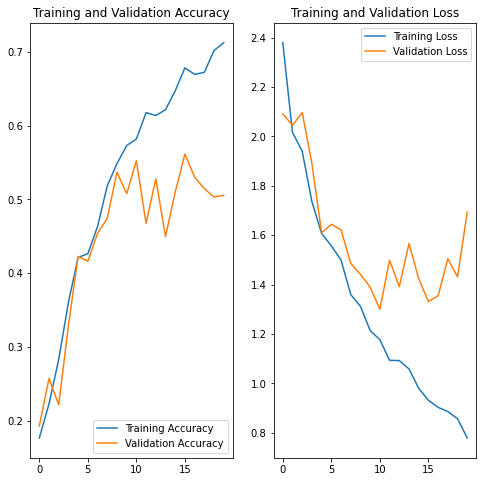

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The findings of model fit for the second model Model 2.


1.   After 20 ehpochs the train accuracy is 0.71 and validation accuracy is 0.52
2.   The train loss got reduced with the number of epochs and settled at  0.78 after 20 epochs whereas the validation loss oscillated betwen 1.5 and 1.6 after 5th epoch
3. The train accuaracy is less compared to the previous model (Model 1)
4. There is a significant difference between train and validation accuracy
5. The model still suffers from accuracy and there is clear sign of overfitting again
6. The only improvement of this model (Model 2) compared to previous model (Model 1) is that as instead of the validation loss getting increased after 6th epoch as in the Model 1, it got reduced and oscillated between 1.5 and 1.6

#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

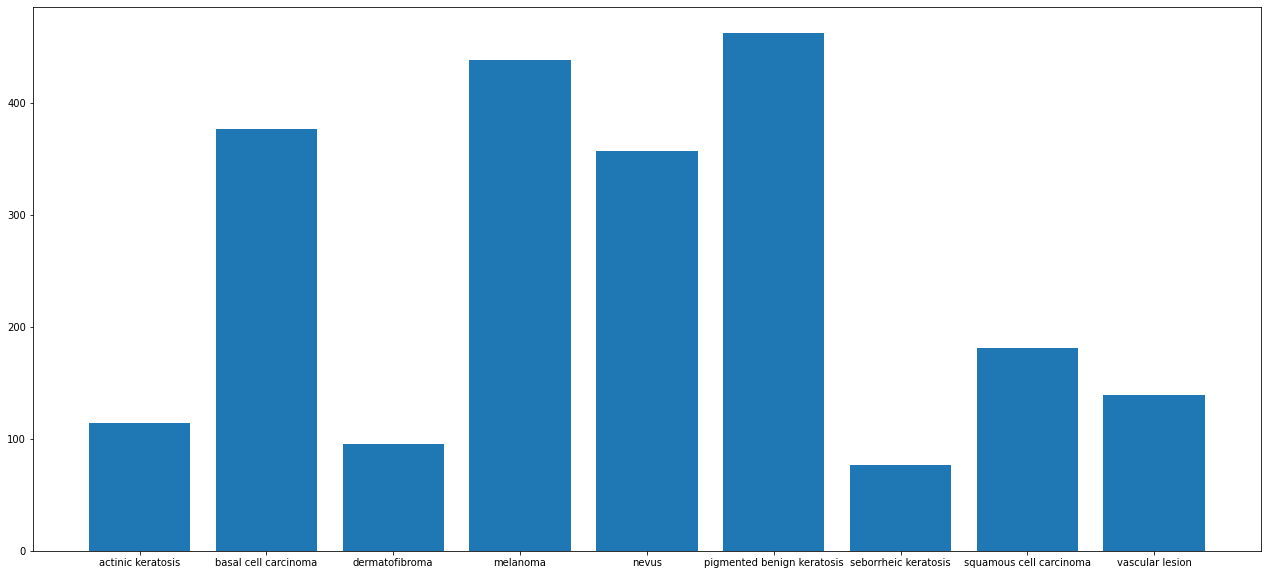

In [42]:
#Plotting bar plot for observing the distribution of image files in each class
count = []
for i in class_names:
  count.append(len(list(data_dir_train.glob(i + '/*.jpg'))))
plt.figure(figsize=(22,10))
plt.bar(class_names, count)

#### Writing the findings here about the distribution



*   The seborrheic keratosis class has got least number of samples
*   Classes 'pigmented benign keratosis' and 'melanoma' dominate the data in terms proportionate number of samples



#### Rectifying the class imbalance with augmentor library
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor









To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    path = str(path_to_training_dataset) + '/' + i
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A2EEAB90>: 100%|██████████| 500/500 [00:28<00:00, 17.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A3D6ADD0>: 100%|██████████| 500/500 [00:24<00:00, 20.16 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A2EFAA90>: 100%|██████████| 500/500 [00:24<00:00, 20.08 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F11A2DBDAD0>: 100%|██████████| 500/500 [01:36<00:00,  5.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1019x717 at 0x7F11A2E128D0>: 100%|██████████| 500/500 [01:20<00:00,  6.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A2F0F8D0>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F11A2D93E50>: 100%|██████████| 500/500 [00:49<00:00, 10.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F121E0FE710>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/MyDrive/Skin_Cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F11A2E8B150>: 100%|██████████| 500/500 [00:21<00:00, 23.31 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [48]:
len(lesion_list_new)

4500

In [49]:
# path_list_new is changed to path_list as path_list_new is not present, as suggested during TA connect
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# below line from the origional code is commented as original_df is not present, as suggested during TA connect
#new_df = original_df.append(df2)

In [51]:
# Again new_df is commented as suggested during the TA connect
#new_df['Label'].value_counts()
df2['Label'].value_counts()

seborrheic keratosis          500
pigmented benign keratosis    500
basal cell carcinoma          500
dermatofibroma                500
squamous cell carcinoma       500
actinic keratosis             500
melanoma                      500
vascular lesion               500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [53]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Let us create a model including normalization (Model 3)

In [60]:

num_classes = len(class_names)
model = Sequential([
               layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
               layers.Conv2D(16, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Conv2D(32, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Conv2D(64, 3, padding='same', activation='relu'),
               layers.MaxPooling2D(),
               layers.Dropout(0.2),
               layers.Flatten(),
               layers.Dense(128, activation='relu'),
               layers.Dense(num_classes, activation='softmax')
])

#### Compiling the model (Model 3)

In [62]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [63]:
# Let us see the model summary (Model 3)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### Let us train the model (Model 3) after augmenting 500 images in each class

In [64]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 40s 223ms/step - loss: 2.2272 - accuracy: 0.1754 - val_loss: 2.0379 - val_accuracy: 0.2153
Epoch 2/30
169/169 [==============================] - 38s 218ms/step - loss: 1.7511 - accuracy: 0.3320 - val_loss: 1.6061 - val_accuracy: 0.4246
Epoch 3/30
169/169 [==============================] - 38s 219ms/step - loss: 1.5034 - accuracy: 0.4245 - val_loss: 1.4430 - val_accuracy: 0.4603
Epoch 4/30
169/169 [==============================] - 38s 219ms/step - loss: 1.3453 - accuracy: 0.4818 - val_loss: 1.4828 - val_accuracy: 0.4588
Epoch 5/30
169/169 [==============================] - 38s 220ms/step - loss: 1.3017 - accuracy: 0.5085 - val_loss: 1.2814 - val_accuracy: 0.5234
Epoch 6/30
169/169 [==============================] - 38s 219ms/step - loss: 1.1422 - accuracy: 0.5727 - val_loss: 1.1772 - val_accuracy: 0.5605
Epoch 7/30
169/169 [==============================] - 38s 219ms/step - loss: 1.0548 - accuracy: 0.6105 - val_loss: 1.2572 - val_ac

#### Visualization of the model results

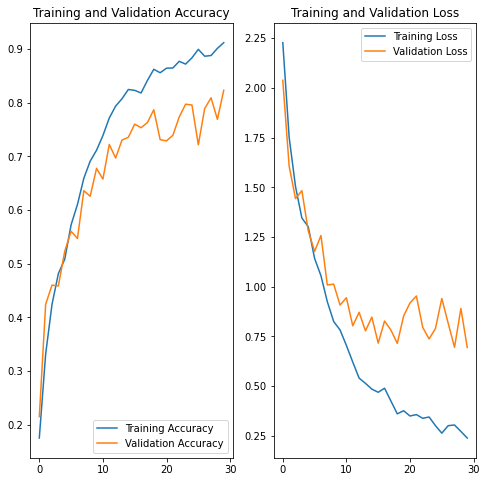

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of model accuaracy, loss, overfit and underfit



Looking at the logs and the graph following are the observations


1.   For both the train and validation the accuracy increased and the loss decreased with number of epochs 
2.   After 30 epochs the train accuracy is 0.9416 and validation accuracy is 0.8337
3.   The amount loss after 30 epochs for train and validation is 0.1457 and 0.6281 respectively
4.   It can be concluded that 

  *   The model is now free from both underfitting and
      overfitting

  *   The class rebalance has really helped to achieve 
      higher accuracy and significant reduction in the
      loss compared to the model with less number of
      data set and class imbalance


# Perform prediction the test data

In [66]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              batch_size=batch_size,
                                                              image_size = (180,180),
                                                              seed=123, validation_split=None,
                                                              subset=None
                                                               )

Found 118 files belonging to 9 classes.


In [68]:
test_batch = test_ds.take(1)

In [69]:
for images, labels in test_batch:
  for i in range(9):
    img_arr = tf.keras.utils.img_to_array(images[i])
    img_arr = tf.expand_dims(img_arr, 0)
    predictions = model.predict(img_arr)
    score = tf.nn.softmax(predictions[0])
    print(
    "This image most likely belongs to {} "
    .format(class_names[np.argmax(score)])
    )  

This image most likely belongs to nevus 
This image most likely belongs to nevus 
This image most likely belongs to pigmented benign keratosis 
This image most likely belongs to actinic keratosis 
This image most likely belongs to nevus 
This image most likely belongs to basal cell carcinoma 
This image most likely belongs to pigmented benign keratosis 
This image most likely belongs to nevus 
This image most likely belongs to nevus 
